# Person of Interest Model
## Udacity's Introduction to Machine Learning course
###### Written by aaraeus

## TO DO LIST: (Updated 03/03/2019)

Alright, so we've figured out AdaBoost might be our best bet, but I'm pretty sure that the lack of POIs in the Y data is what's killing our results here. I've used GridSearchCV() to tune a few parameters, but these classifiers are really as only good as the train/test data I feed it!

I need to read up on StratifiedShuffleSplit(), which is what the tester code is using. But for now... sleep.

**Other helpful repositories as of 2019**
- https://github.com/tybyers/Udacity_IntroMachineLearning/blob/master/Question_Responses.ipynb

- https://github.com/soukiassianb/Udacity-Machine-Learning-Enron-Dataset/blob/master/poi_id.ipynb

- https://devpost.com/software/enron-identify-fraud

## Introduction
The goal here is to identify whether someone might be a person of interest in a fraud investigation into the Enron scandal. Enron was a company that committed a large amount of fraudulent activities, effectively rigging the market to create profit. The question we are trying to solve is, what other people, aside from the people already identified as a POI from previous litigation action, could have been actively and knowingly involved? Since we have a large amount of open data, including emails, we can train a machine learning model to look at these features and attempt to predict whether someone is a person of interest or not. 

## Section 1: Initialisation, data loading and imports

Here we're just initialising the working directory to make editing items a little easier. I've placed all the features into their own lists, and then created a final features list to work with.

In [395]:
# define the path of the directory in here
path = '/Users/kintesh/Documents/udacity_ml/python3'

import sys
import pickle
import os
import pandas as pd
import matplotlib.pyplot
import seaborn as sn
import numpy as np

os.chdir(path)

sys.path.append("ud120-projects/tools/")
sys.path.append("ud120-projects/final_project/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

financial_features_list = ["salary", "deferral_payments", "total_payments", "loan_advances", 
                           "bonus", "restricted_stock_deferred", "deferred_income", 
                           "total_stock_value", "expenses", "exercised_stock_options", 
                           "other", "long_term_incentive", "restricted_stock", "director_fees"]

email_features_list = ["to_messages", "from_poi_to_this_person",
                       "from_messages", "from_this_person_to_poi", "shared_receipt_with_poi"]

target_label = ["poi"]

full_features_list = target_label + financial_features_list + email_features_list
features_list = financial_features_list + email_features_list
financial_features_list = target_label + financial_features_list
email_features_list = target_label + email_features_list

### Load the dictionary containing the dataset
data_dict = pickle.load(open("ud120-projects/final_project/final_project_dataset.pkl", "rb") )

## Section 2: Outlier identification & removal

The first step of any machine learning project is to start graphing some data to check for outliers. The most obvious starting point is to chart salary and bonus as we did earlier in the course, so let's do that first.

There are two obvious outliers. "The Travel Agency In The Park" isn't a persion, so let's remove this.

Also, "Mr Eugene E Lockhart" doesn't contribute anything to the dataset since his values are all empty!

Mr Lockhart's values:
{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'loan_advances': 'NaN', 'bonus': 'NaN', 'email_address': 'NaN', 'restricted_stock_deferred': 'NaN', 'deferred_income': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'from_poi_to_this_person': 'NaN', 'exercised_stock_options': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'long_term_incentive': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock': 'NaN', 'director_fees': 'NaN'}


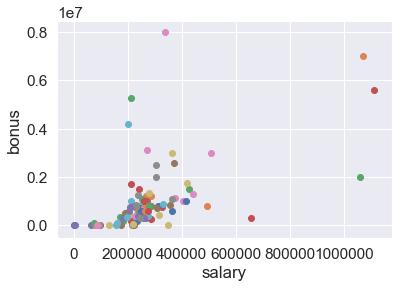

In [396]:
### Task 2: Remove outliers
sys.path.append("ud120-projects/outliers/")
from outlier_cleaner import outlierCleaner

features = ["salary", "bonus"]

# Remove the TOTAL key, since this is going to skew our results. Also remove the 
#"travel agency in the park" record since that isn't a person.
print("Mr Lockhart's values:")
print(data_dict['LOCKHART EUGENE E'])

data_dict.pop('TOTAL', 0)
data_dict.pop("THE TRAVEL AGENCY IN THE PARK", 0)
data_dict.pop('LOCKHART EUGENE E', 0)

data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

In [397]:
# Find other outliers if I can. Loop through everyone, 
# and output those that have salaries above 600k and bonuses above 4m.

#First, find salary outliers.
print('-'*20)
print('Salary outliers:')
print('-'*20)
for names, value in data_dict.items():
    if data_dict[names]["salary"] != 'NaN' and data_dict[names]["salary"] >= 600000:
        print("Name: ", names)
        print("Salary: ", value['salary'])
    
print('-'*20)
print('Bonus outliers:')
print('-'*20)

#Second, find bonus outliers.
for names, value in data_dict.items():
    if data_dict[names]["bonus"] != 'NaN' and data_dict[names]["bonus"] >= 4000000:
        print("Name: ", names)
        print("Bonus: ", value['bonus'])
        
print('-'*20)
print('Salary & Bonus outliers:')
print('-'*20)

#Third, look at the combination of the two.
for names, value in data_dict.items():
    if data_dict[names]["bonus"] != 'NaN' and data_dict[names]["bonus"] >= 4000000 and data_dict[names]["salary"] != 'NaN' and data_dict[names]["salary"] >= 600000:
        print("Name: ", names)
        print("Salary: ", value['salary'])
        print("Bonus: ", value['bonus'])

--------------------
Salary outliers:
--------------------
Name:  LAY KENNETH L
Salary:  1072321
Name:  SKILLING JEFFREY K
Salary:  1111258
Name:  PICKERING MARK R
Salary:  655037
Name:  FREVERT MARK A
Salary:  1060932
--------------------
Bonus outliers:
--------------------
Name:  LAVORATO JOHN J
Bonus:  8000000
Name:  LAY KENNETH L
Bonus:  7000000
Name:  BELDEN TIMOTHY N
Bonus:  5249999
Name:  SKILLING JEFFREY K
Bonus:  5600000
Name:  ALLEN PHILLIP K
Bonus:  4175000
--------------------
Salary & Bonus outliers:
--------------------
Name:  LAY KENNETH L
Salary:  1072321
Bonus:  7000000
Name:  SKILLING JEFFREY K
Salary:  1111258
Bonus:  5600000


Here I'm making a judgement call to keep these people, like Kenneth Lay and Jevvrey Skilling, in our dataset. The people with the highest salaries were, in fact, POIs, so it does make sense to keep them in the data, despite the fact that they are outliers and may skew our model slightly. Models can never be completely rid of bias.

## Section 3: Create new features

Here, we're creating new features and adding their name to our features_list.

Create some new features below and test them out in our feature importance list.

I want to create:

1. A Salary Ratio, which is your salary as a % of total payments. Are people who had a low salary ratio (i.e. had ridiculously high total payments) more likely to be a POI? Kenneth Lay certainly did.

2. Expenses ratio, so the expenses as a % of the total salary. Did people who had higher expenses get cozy in the knowledge that they'd uncovered something special? 

3. Exercised Stock Ratio, which is exercised stock options as a proportion of total stock (exercised stock options, restricted stock, restricted stock deferred). Maybe people who knew about the 'scam' tried to exercise all their stock towards the fall of Enron?

In [398]:
### Task 3: Create new feature(s)

for person in data_dict:
    # Salary Ratio
    if data_dict[person]['salary'] == 'NaN' or data_dict[person]['total_payments'] == 'NaN':
            data_dict[person]['salary_ratio'] = '0'
    else:
        data_dict[person]['salary_ratio'] = float(data_dict[person]['salary']) / float(data_dict[person]['total_payments'])
    
    # Expenses Ratio
    if data_dict[person]['expenses'] == 'NaN' or data_dict[person]['salary'] == 'NaN':
            data_dict[person]['expenses_ratio'] = '0'
    else:
        data_dict[person]['expenses_ratio'] = float(data_dict[person]['expenses']) / float(data_dict[person]['salary'])        
    
    # Exercised Stock Ratio
    if data_dict[person]['exercised_stock_options'] == 'NaN' or data_dict[person]['total_stock_value'] == 'NaN':
            data_dict[person]['exercised_stock_ratio'] = '0'
    else:
        data_dict[person]['exercised_stock_ratio'] = float(data_dict[person]['exercised_stock_options']) / float(data_dict[person]['total_stock_value'])

# Add these features to my features_list
features_list.append('salary_ratio')
features_list.append('expenses_ratio')
features_list.append('exercised_stock_ratio')

In [399]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Print features_list and an example, to make sure the data has our created features in it.
print('-'*30)
print('Features_list:')
print('-'*30)
print(features_list)

print('-'*30)
print('Keys in "my_dataset":')
print('-'*30)

for key in my_dataset[person].keys():
    print(key)
    
# print(my_dataset['LAY KENNETH L'])

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

------------------------------
Features_list:
------------------------------
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'salary_ratio', 'expenses_ratio', 'exercised_stock_ratio']
------------------------------
Keys in "my_dataset":
------------------------------
salary
to_messages
deferral_payments
total_payments
loan_advances
bonus
email_address
restricted_stock_deferred
deferred_income
total_stock_value
expenses
from_poi_to_this_person
exercised_stock_options
from_messages
other
from_this_person_to_poi
poi
long_term_incentive
shared_receipt_with_poi
restricted_stock
director_fees
salary_ratio
expenses_ratio
exercised_stock_ratio


## Section 4: Initial Feature Selection

I'm going to use an ensemble classifer to find the rough importance of each feature, then use SelectKBest to give me rough idea of what features are most predictive. But first, put my *data_dict* into a dataframe since I need to split out the POI label and all our features into training and target datasets.

In [400]:
enron_df = pd.DataFrame.from_dict(data_dict)
enron_df = enron_df.transpose()
enron_df = enron_df.drop('email_address', 1)

# Replace NaN values to 0 - some of these might be strings, so uh, try that too.
enron_df.fillna(0, inplace=True)
enron_df = enron_df.replace("NaN", 0)

#Splits the dataframe into a series (the poi column) and the rest of the dataframe, and replaces "NaN" with 0.
poi_labels = enron_df['poi']
no_pois = enron_df.drop('poi', 1)
no_pois = no_pois.replace("NaN", 0)

# poi_labels.head(n=5)
# no_pois.head(n=5)

# Check YEAP SOON's data to see if we're OK

# enron_df.loc['YEAP SOON']

Now let's take a look at a DecisionTreeClassifier and find the feature importance for each variable.

In [401]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(no_pois, poi_labels)

print('-'*30)
print('FEATURE IMPORTANCE %:')
print('-'*30)
for name, importance in zip(list(no_pois.columns.values), model.feature_importances_):
    imp_perc = round(importance * 100,2)
    print(name, "=", imp_perc)

------------------------------
FEATURE IMPORTANCE %:
------------------------------
bonus = 10.91
deferral_payments = 0.0
deferred_income = 0.0
director_fees = 0.0
exercised_stock_options = 24.22
exercised_stock_ratio = 0.0
expenses = 6.49
expenses_ratio = 0.0
from_messages = 5.56
from_poi_to_this_person = 0.0
from_this_person_to_poi = 6.51
loan_advances = 0.0
long_term_incentive = 0.0
other = 13.9
restricted_stock = 17.02
restricted_stock_deferred = 0.0
salary = 0.0
salary_ratio = 12.21
shared_receipt_with_poi = 0.0
to_messages = 0.0
total_payments = 0.0
total_stock_value = 3.18


Now let's use SelectPercentile to find the top x% variables.

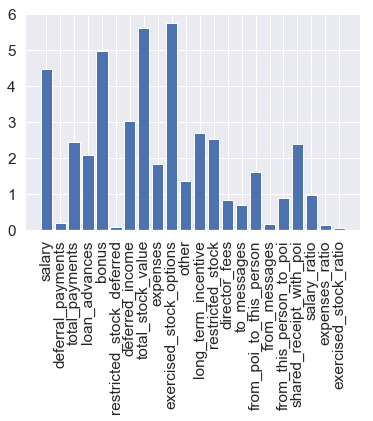

In [402]:
# First, try using SelectKBest to find the best features.
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile

# Perform feature selection
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(enron_df[features_list], enron_df['poi'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores. 
matplotlib.pyplot.bar(range(len(features_list)), scores)
matplotlib.pyplot.xticks(range(len(features_list)), features_list, rotation='vertical')
matplotlib.pyplot.show()

From the importances list, you can see the most important features seem to be the following:

['bonus','exercised_stock_options','expenses','from_messages','restricted_stock','salary_ratio']

But from the SelectPercentile list, the most important features seem to be:

['exercised_stock_options','total_stock_value','salary','bonus','expenses','from_poi_to_this_person']

Update our features_list accordingly, and use this as a basic list to trial for a few models.

Initially, I only went for the second list of six features... but as I started training my models, I realised my accuracy was high (80%+), but my precision and recall fell consistently short, which looks like a **high bias** situation. I therefore dedided to add a few more features, to see if this helped a little.

## Section 5: Data Preparation (Train/Test split)

In this section, we're going to create a *model_features_list* and create two dataframes:
- features_df
- labels_df
Nowe we can create a train/test split.

In [403]:
# model_features_list = ['exercised_stock_options','total_stock_value','salary','bonus','expenses','from_poi_to_this_person',
#                        'shared_receipt_with_poi','total_payments','expenses','restricted_stock']

model_features_list = ['exercised_stock_options','total_stock_value','salary_ratio','bonus','expenses','from_poi_to_this_person',
                       'shared_receipt_with_poi','total_payments','expenses','long_term_incentive']


# print(features)
# print(labels)

# Place labels and features lists into dataframes. Rather than just using the enron data
# use the results of Katie's featureFormat model - there's the features and lebels datasets

# features_df = pd.DataFrame(features, features_list)
# labels_df = pd.DataFrame(labels, ['poi'])

features_df = enron_df[model_features_list]
labels_df = enron_df['poi']

# Now use train_test_split
from sklearn.model_selection import train_test_split

feature_train, feature_test, target_train, target_test = train_test_split(features_df, labels_df, test_size=0.3, 
                                                                          random_state=42)

print("Dataset shapes (rows, columns):")
print("Features train:", feature_train.shape)
print("Target train:", target_train.shape)
print("Features test:", feature_test.shape)
print("Target test:", target_test.shape)

# Double check target_test:
# print(target_test[15:15])

Dataset shapes (rows, columns):
Features train: (100, 10)
Target train: (100,)
Features test: (43, 10)
Target test: (43,)


## Section 6: Classifier Selection

Classifier selection is tricky. Let's try out a bunch of classifiers and append to a dataset manually to compare some results! What gives us a decent enough accuracy score?

In [408]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import classification metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

clf_names = [
    "DecisionTree"
    ,"RandomForest"
    ,"SVM"
    ,"GuassianNB"
#     ,"KMeans"
    ,"AdaBoost"
    ,"KNearestNeighbours"
]

clf_objects = [
    DecisionTreeClassifier()
    ,RandomForestClassifier()
    ,svm.SVC(gamma='auto')
    ,GaussianNB()
#     ,KMeans()
    ,AdaBoostClassifier()
    ,KNeighborsClassifier()
]

# This segment of code is to prove it works on just two classifiers.

# clf_names = ["DecisionTree", "RandomForest"]

# clf_objects = [
#     DecisionTreeClassifier(),
#     RandomForestClassifier()
# ]

#     clf = KNeighborsClassifier(weights='distance', algorithm='ball_tree')


# Create a clf_results_df as empty first before we start looping.
clf_results_df = pd.DataFrame(columns=['clf_name','clf_parameters','clf_features','precision','recall','accuracy'])

# iterate over classifiers
for clf_name, clf_obj in zip(clf_names, clf_objects):
    clf_obj.fit(feature_train, target_train)

    pred = clf_obj.predict(feature_test)

    clf_parameters = "None"
    clf_features = ",".join(model_features_list)
    precision = precision_score(target_test, pred, pos_label=1, average='binary')
    recall = recall_score(target_test, pred, pos_label=1, average='binary')
    accuracy = accuracy_score(target_test, pred)

#     columns=['clf_name','clf_parameters','clf_features','precision','recall','accuracy'], 
#                             data=[[clf_name], [clf_parameters], [clf_features], [precision], [recall], [accuracy]]
        
#     Load this data into a temporary pandas dataframe
    scores_df = pd.DataFrame()
    scores_df['clf_name'] = [clf_name]
    scores_df['clf_parameters'] = [clf_parameters]
    scores_df['clf_features'] = [clf_features]
    scores_df['precision'] = [precision]
    scores_df['recall'] = [recall]
    scores_df['accuracy'] = [accuracy]
                
    clf_results_df = clf_results_df.append(scores_df)
    
    cm = confusion_matrix(target_test, pred)

    df_cm = pd.DataFrame(cm, range(2), range(2))

# Printing a heat map of the confusion matrix
#     print("Model: ", clf_name)
#     sn.set(font_scale=1.4)#for label size
#     sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

print()
print()

print("Overall results: ")
clf_results_final = clf_results_df.transpose()
# print(clf_results_final.to_string())

from IPython.display import display
display(clf_results_final)



Overall results: 


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,0,0,0,0,0
clf_name,DecisionTree,RandomForest,SVM,GuassianNB,AdaBoost,KNearestNeighbours
clf_parameters,None,None,None,None,None,None
clf_features,"exercised_stock_options,total_stock_value,sala...","exercised_stock_options,total_stock_value,sala...","exercised_stock_options,total_stock_value,sala...","exercised_stock_options,total_stock_value,sala...","exercised_stock_options,total_stock_value,sala...","exercised_stock_options,total_stock_value,sala..."
precision,0.363636,1,0,0.166667,0.555556,1
recall,0.8,0.8,0,0.2,1,0.2
accuracy,0.813953,0.976744,0.883721,0.790698,0.906977,0.906977


It looks like the best models to use, based on our initial *model_features_list*, are:

1. Decision Tree
2. Random Forest
3. Gaussian NB
4. Adaboost

Though it's slightly disappointing that our precision/recall are so low, let's see if parameter tuning helps a little.

## Section 7: Parameter Tuning

Tune the parameters. Maybe try GridsearchCV as explained here on Kaggle:

https://www.kaggle.com/evanmiller/pipelines-gridsearch-awesome-ml-pipelines

In [405]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline = Pipeline([
#         ('clf', AdaBoostClassifier())
#         ('clf', DecisionTreeClassifier())
        ('clf', RandomForestClassifier())
#         ('clf', GaussianNB())

    ])

parameters = {
#         ADABOOST
#         'clf__algorithm': ['SAMME', 'SAMME.R'],
#         'clf__n_estimators': [25, 50, 100],
#         'clf__learning_rate': [.5, 1., 1.5]
    
#         DECISION TREE
#           'clf__max_depth': [3, 6, 9, 12, 15, 20],
#           'clf__min_samples_leaf': [1, 5, 10, 20, 50, 100]

#         RANDOM FOREST
        'clf__n_estimators': [25, 30, 50, 80, 100],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [3, 6, 9, 12, 15, 20]
    
        # GAUSSIAN NB
        # None, since GaussianNB only requires 'prior' as a thingie.
}

CV = GridSearchCV(pipeline, parameters, scoring = 'recall')

CV.fit(feature_train, target_train)   

print('Best score and parameter combination = ')

print(CV.best_score_)    
print(CV.best_params_)   

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best score and parameter combination = 
0.39799999999999996
{'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_split': 6, 'clf__n_estimators': 25}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Results of each algorithm through the GridSearchCV are as follows:
```Python
Adaboost:
Best score and parameter combination = 
0.39799999999999996
{'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 1.0, 'clf__n_estimators': 25}

DecisionTree:
Best score and parameter combination = 
0.39799999999999996
{'clf__max_depth': 6, 'clf__min_samples_leaf': 1}

RandomForest:
Best score and parameter combination = 
0.33
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_split': 6, 'clf__n_estimators': 30}
```

So from our 3 tunable classifiers, Adaboost was the one that worked best up above, and has a recall of 0.397, based on our train/test split.

I think we're limited by the test data here... maybe I could use a stratifiedshufflesplit() to remove the issue of having such a small set of target labels?

## Section 8: Final model creation

Well, we've picked AdaBoost. Let's go with that!

,clf_name,clf_parameters,clf_features,precision,recall,accuracy
0,AdaBoost,"{'clf__algorithm': 'SAMME.R', 'clf__learning_r...","exercised_stock_options,total_stock_value,sala...",0.555556,1.0,0.906977


Model:  AdaBoost


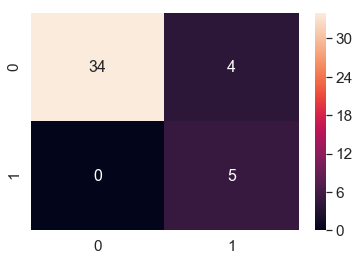

In [406]:
clf = AdaBoostClassifier(algorithm ='SAMME.R', learning_rate = 1.0, n_estimators = 25)

clf.fit(feature_train, target_train)

pred = clf.predict(feature_test)

clf_name = 'AdaBoost'
clf_parameters = "None"
clf_features = ",".join(model_features_list)
precision = precision_score(target_test, pred, pos_label=1, average='binary')
recall = recall_score(target_test, pred, pos_label=1, average='binary')
accuracy = accuracy_score(target_test, pred)

#     columns=['clf_name','clf_parameters','clf_features','precision','recall','accuracy'], 
#                             data=[[clf_name], [clf_parameters], [clf_features], [precision], [recall], [accuracy]]

#     Load this data into a temporary pandas dataframe
final_scores_df = pd.DataFrame()
final_scores_df['clf_name'] = [clf_name]
final_scores_df['clf_parameters'] = [str({'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 1.0, 'clf__n_estimators': 25})]
final_scores_df['clf_features'] = [clf_features]
final_scores_df['precision'] = [precision]
final_scores_df['recall'] = [recall]
final_scores_df['accuracy'] = [accuracy]

cm = confusion_matrix(target_test, pred)

df_cm = pd.DataFrame(cm, range(2), range(2))

display(final_scores_df)

# Printing a heat map of the confusion matrix
print("Model: ", clf_name)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [407]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, target_label + features_list)

# pickle.dump(clf, open("my_classifier.pkl", "wb") )
# pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
# pickle.dump(model_features_list, open("my_feature_list.pkl", "wb") )

Tester_py file results are:
``` Python

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=25, random_state=None)
	Accuracy: 0.82713	Precision: 0.30659	Recall: 0.23500	F1: 0.26606	F2: 0.24651
	Total predictions: 15000	True positives:  470	False positives: 1063	False negatives: 1530	True negatives: 11937
```